In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# load data

In [2]:
q = "select * from bidders"
bids = redshift_query_read(q, schema='production')

In [3]:
q = "select * from auctionitem"
items = redshift_query_read(q, schema="production")

In [4]:
# merge bids w/ auction item details
bids = bids.merge(items.drop('id', axis=1), on='product')

In [5]:
bids.tail(3)

,ticketholder,form,product,amount,date_created,winner,maxbid,reserve,bidincrement,number,value
8255983,0,970104,123792,20.0,2021-04-29 14:40:53,55123,0.0,0.0,0.0,33,0.0
8255984,0,961509,104457,500.0,2020-09-24 20:39:26,27679,0.0,0.0,25.0,16,2500.0
8255985,0,967901,116249,1.0,2021-01-15 10:58:37,46020,0.0,0.0,1.0,1,0.0


In [7]:
"{:,}".format(len(bids))

'8,255,986'

# analysis

### bid increment

In [103]:
increments = bids.groupby('bidincrement')['amount'].agg(['mean', 'median', 'count']).reset_index()
increments['ratio'] = increments['median'] / increments['bidincrement']
increments

,bidincrement,mean,median,count,ratio
0,0.0,126077.677228,400.0,96198,inf
1,1.0,15.564717,15.0,40484,15.000000
2,2.0,56.071809,34.0,13146,17.000000
3,3.0,22.000000,24.0,12,8.000000
4,4.0,4.000000,4.0,8,1.000000
5,5.0,50.561041,40.0,85320,8.000000
6,10.0,162.679055,100.0,161118,10.000000
7,15.0,35.000000,30.0,60,2.000000
8,20.0,189.692833,160.0,1172,8.000000
9,25.0,820.575702,575.0,258634,23.000000


In [104]:
values = bids.groupby('bidincrement')['value'].agg(['mean', 'median', 'count']).reset_index()
values['ratio'] = values['median'] / values['bidincrement']
values

,bidincrement,mean,median,count,ratio
0,0.0,766.231938,50.0,96198,inf
1,1.0,1.075487,0.0,40484,0.000000
2,2.0,39.569451,60.0,13146,30.000000
3,3.0,48.333333,50.0,12,16.666667
4,4.0,0.000000,0.0,8,0.000000
5,5.0,112.397984,100.0,85320,20.000000
6,10.0,152.721471,50.0,161118,5.000000
7,15.0,92.000000,60.0,60,4.000000
8,20.0,325.912969,300.0,1172,15.000000
9,25.0,1665.730716,2500.0,258634,100.000000


### assigned item value

In [105]:
prod_vals = bids.groupby('product')['amount'].agg(['max', 'mean', 'median', 'count']).reset_index()
prod_vals.columns = ['product', 'max bid', 'mean bid', 'median bid', 'bids']
prod_vals['bidincrement'] = prod_vals['product'].apply(lambda x: bids[bids['product']==x]['bidincrement'].iloc[0])
prod_vals['value'] = prod_vals['product'].apply(lambda x: bids[bids['product']==x]['value'].iloc[0])

In [106]:
prod_vals.tail(3)

,product,max bid,mean bid,median bid,bids,bidincrement,value
726,87946,50.0,50.0,50.0,2,10.0,250.0
727,87949,15.0,15.0,15.0,2,3.0,35.0
728,87969,24.0,22.5,22.5,4,3.0,50.0


In [109]:
val_ranges = [(0, 25), (25, 100), (100, 500),
              (500, 1000), (1000)]
for i in val_ranges:
    try:
        these_prod_vals = prod_vals[(prod_vals['value']>=i[0])&(prod_vals['value']<i[1])]
    except:
        these_prod_vals = prod_vals[prod_vals['value']>=i]
    
    print(i)
    print(these_prod_vals.groupby('bidincrement').agg({'max bid': 'median', 'mean bid': 'count', 'bids': 'median'}))
    print()

(0, 25)
              max bid  mean bid  bids
bidincrement                         
0.0             450.0        31   8.0
1.0              12.0        11  26.0
2.0              26.0        19  24.0
4.0               4.0         1   8.0
5.0              40.0        23  14.0
10.0             80.0        12  15.0
20.0            160.0         5  20.0
25.0            225.0        28  14.0
50.0            425.0        10  21.0

(25, 100)
              max bid  mean bid     bids
bidincrement                            
0.0            4650.0         2  10382.0
1.0              12.5         2     39.0
2.0              22.0         6     44.0
3.0              24.0         5      2.0
5.0              50.0        51     20.0
10.0             75.0        30     48.0
15.0             30.0         1     32.0

(100, 500)
              max bid  mean bid  bids
bidincrement                         
0.0              93.0        12  20.0
5.0             100.0        84  41.0
10.0            100.0       11

### winning bid item value

In [110]:
val_ranges = [(0, 25), (25, 100), (100, 500),
              (500, 1000), (1000)]
for i in val_ranges:
    try:
        these_prod_vals = prod_vals[(prod_vals['max bid']>=i[0])&(prod_vals['max bid']<i[1])]
    except:
        these_prod_vals = prod_vals[prod_vals['max bid']>=i]
    
    print(i)
    print(these_prod_vals.groupby('bidincrement').agg({'max bid': 'median', 'mean bid': 'count', 'value': 'mean', 'bids': 'median'}))
    print()

(0, 25)
              max bid  mean bid       value    bids
bidincrement                                       
0.0               1.0         9   55.555556    16.0
1.0               8.5        10    8.500000    23.0
2.0              18.0        13   14.923077    14.0
3.0              24.0         5   48.000000     2.0
4.0               4.0         1    0.000000     8.0
5.0              15.0        13   50.769231     8.0
10.0             15.0         4  175.000000  1002.0

(25, 100)
              max bid  mean bid       value    bids
bidincrement                                       
0.0              55.0         9  169.444444    12.0
1.0              28.0         3    8.333333  7882.0
2.0              40.0        10    3.000000    42.0
5.0              50.0        95   87.526316    14.0
10.0             60.0        72  120.972222    10.0
15.0             45.0         3  103.333333    16.0
20.0             60.0         5  128.000000     6.0
25.0             50.0        25  212.560000  

### repeat bids

In [46]:
prod_bids = bids.groupby('product')['ticketholder'].agg(['count', 'nunique']).reset_index()
prod_bids['repeat_rate'] = prod_bids['count'] / prod_bids['nunique']
prod_repeat_rates = prod_bids.groupby('product')['repeat_rate'].agg(['mean', 'median']).reset_index()
prod_repeat_rates.columns = ['product', 'mean_repeat_rate', 'median_repeat_rate']
bids = bids.merge(prod_repeat_rates, on='product')

bids.groupby('bidincrement')[['mean_repeat_rate', 'median_repeat_rate']].agg(['mean', 'count']).reset_index()

bidincrement mean_repeat_rate         median_repeat_rate        
                            mean   count               mean   count
0           0.0         3.343011   48099           3.343011   48099
1           1.0        15.496047   20242          15.496047   20242
2           2.0         2.343994    6573           2.343994    6573
3           3.0         1.333333       6           1.333333       6
4           4.0         1.000000       4           1.000000       4
5           5.0         3.239633   42660           3.239633   42660
6          10.0         2.910579   80559           2.910579   80559
7          15.0         1.200000      30           1.200000      30
8          20.0         2.383118     586           2.383118     586
9          25.0         4.738603  129317           4.738603  129317
10         30.0         2.000000       6           2.000000       6
11         50.0         2.144803   62116           2.144803   62116
12         75.0         1.000000       1           1.000000       1
13        100.0         3.134694   33615           3.134694   33615
14        150.0         1.000000       8           1.000000       8

### bidding timeframe

In [47]:
prod_timerange = bids.groupby('product')['date_created'].agg(['min', 'max', 'count']).reset_index()
prod_timerange['duration'] = prod_timerange['max'] - prod_timerange['min']
prod_timerange.tail(3)

,product,min,max,count,duration
726,87946,2019-12-02 00:34:11,2019-12-02 00:34:11,1,0 days 00:00:00
727,87949,2019-12-02 02:41:23,2019-12-02 02:41:23,1,0 days 00:00:00
728,87969,2019-12-01 22:13:14,2019-12-02 02:42:47,2,0 days 04:29:33


In [48]:
prod_timerange['duration'].agg(['mean', 'median'])

mean     5 days 11:41:20.886145404
median             0 days 01:16:40
Name: duration, dtype: timedelta64[ns]

In [49]:
prod_timerange.columns = ['product', 'first_bid', 'last_bid', 'count', 'duration']
bids = bids.merge(prod_timerange[['product', 'first_bid', 'last_bid']], on='product')
bids['minutes_since_first_bid'] = bids['date_created'] - bids['first_bid']
bids['minutes_until_last_bid'] = bids['last_bid'] - bids['date_created']

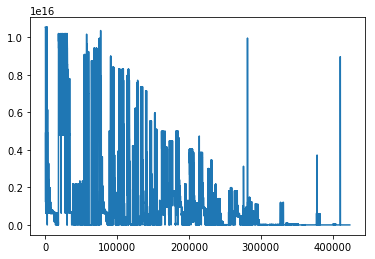

In [50]:
bids['minutes_since_first_bid'].plot()

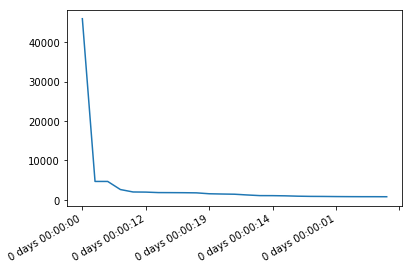

In [59]:
bids['minutes_until_last_bid'].value_counts()[:25].plot()

In [60]:
bids['minutes_until_last_bid'].value_counts(normalize=True)[:20]

0 days 00:00:00     0.108432
0 days 00:00:05     0.011007
0 days 00:00:03     0.011005
0 days 00:00:09     0.006156
0 days 00:00:11     0.004698
0 days 00:00:12     0.004622
0 days 00:00:08     0.004332
0 days 00:00:04     0.004304
0 days 00:00:02     0.004261
0 days 00:00:06     0.004172
0 days 00:00:19     0.003631
0 days 00:00:07     0.003478
0 days 00:00:16     0.003353
0 days 00:00:10     0.002907
15 days 18:51:46    0.002520
0 days 00:00:14     0.002499
0 days 00:00:15     0.002390
0 days 00:00:27     0.002178
0 days 00:00:47     0.002060
0 days 00:00:24     0.002022
Name: minutes_until_last_bid, dtype: float64

In [63]:
bids.groupby('bidincrement')['minutes_until_last_bid'].agg(['mean', 'median', 'count']).reset_index()

,bidincrement,mean,median,count
0,0.0,14 days 20:49:16.632404,7 days 00:51:30,48099
1,1.0,19 days 03:44:50.399664064,21 days 22:48:55,20242
2,2.0,12 days 21:40:11.519701810,0 days 00:02:05,6573
3,3.0,0 days 00:44:55.500000,0 days 00:00:00,6
4,4.0,0 days 00:00:00,0 days 00:00:00,4
5,5.0,17 days 02:33:31.089732770,0 days 15:40:32,42660
6,10.0,26 days 10:27:34.809754341,16 days 00:55:46,80559
7,15.0,0 days 00:11:54.500000,0 days 00:00:00,30
8,20.0,0 days 03:03:36.569965870,0 days 00:56:00,586
9,25.0,48 days 21:47:01.650780640,34 days 18:36:18,129317
